© 2018 Suzy Beeler. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](bacterial_growth_revisited.ipynb).
___

# Objective 

Now that we've learned a little about Bayesian inference, we will revisit the bacterial growth problem and learn how we can determine the posterior probability distribution for a parameter value (i.e. the growth rate) given our data. What makes Bayesian inference so powerful is that we won't just know the most likely growth rate as we did before, but we will now know the likelihood of a *range* of possible growth rates. 

**JB:** *Don't use the word likelihood here. That has a specific meaning. Say that we know about the probability density function of all possible growth rates.*

# Revisiting the bacterial growth data

In [1]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For pretty plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# used for opening csv files and manipulating data spreadsheets
import pandas as pd

From the image analysis we previously did, we ultimately ended up with the area of bacteria over time, normalized such that the area was $1$ at $t=0$. Let's load in this data using `pandas`, an incredibly useful package that can be used to read in, manipulate, and create dataframes (i.e. spreadsheets).

**JB:** *Data frames are definitely not spreadsheets. Importantly, they lack the concurrency of spreadsheets. I would just call them useful data types for analysis. Also, in the cell below, I changed the path so it works on my machine. Don't change the cell!*

In [3]:
# use pandas to read in the file into a dataframe
dataframe = pd.read_csv("./normalized_bacterial_areas.csv")

# show the data
dataframe

,area,time(mins)
0,1.000000,0
1,1.154062,5
2,1.408350,10
3,1.583774,15
4,1.946165,20
5,2.222030,25
6,2.800410,30
7,3.081454,35
8,3.830295,40
9,4.333154,45


We see that data is formatted in two columns, one with the normalized area, and one with the corresponding time in minutes. Let's re-plot the data to remind ourselves what it looks like.

**JB:** *Pro tip: Put a semicolon after the last line of a Jupyter cell if you do not want the output to appear (thereby getting rid of the annoying `Text(...)`.*

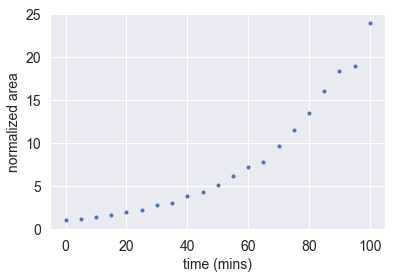

In [4]:
# extract the areas and times from the dataframe
areas = dataframe["area"]
times = dataframe["time(mins)"]

# plot the data
plt.plot(times, areas, '.')
plt.xlabel("time (mins)")
plt.ylabel("normalized area");

Great! We still see an exponential growth curve. Now how do we go about using Bayesian inference to determine the probability of certain growth rates given the data that we have here?

**JB:** *You might want to have a discussion on the outlier here. Look at the original image and see how your segmentation method did with it. If it is an obvious failure, you might attempt to fix it, or delete it.*

In [5]:
import emcee
import scipy.stats as st

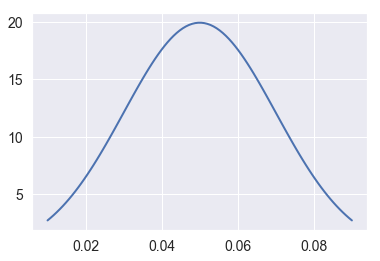

In [35]:
# prior on k 
k = np.linspace(0.01,0.09,100)
prior_k = st.norm.pdf(k, 0.05, 0.02)
plt.plot(k, prior_k)

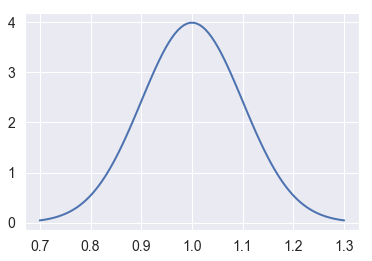

In [34]:
# prior on N0
N0 = np.linspace(.7,1.3,100)
prior_N0 = st.norm.pdf(N0, 1, 0.1)
plt.plot(N0, prior_N0)

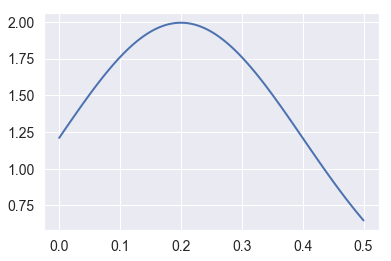

In [37]:
# prior on sigma
sigma = np.linspace(0,0.5,100)
prior_sigma = st.norm.pdf(sigma, 0.2, 0.2)
plt.plot(sigma, prior_sigma)

In [8]:
def log_posterior(params, t, area):
    if np.any(params < 0):
        return -np.inf

    k, N0, sigma = params
    
    # Prior
    log_prior_k = st.norm.logpdf(k, 0.05, 0.02)
    log_prior_N0 = st.norm.logpdf(N0, 1, 0.1)
    log_prior_sigma = st.norm.logpdf(sigma, 0.2, 0.2)
    
    # Likelihood
    log_like = np.sum(st.norm.logpdf(area, N0*np.exp(k*t), sigma))
    
    return log_prior_k + log_prior_N0 + log_prior_sigma + log_like

n_chains = 20
sampler = emcee.EnsembleSampler(n_chains, 
                                3, 
                                log_posterior, 
                                args=(dataframe['time(mins)'].values,
                                      dataframe['area'].values))

p0_k = np.random.normal(0.05, 0.005, size=n_chains)
p0_N0 = np.random.normal(1, 0.01, size=n_chains)
p0_sigma = np.random.normal(0.2, 0.01, size=n_chains)
p0 = np.vstack((p0_k, p0_N0, p0_sigma)).T

sampler.run_mcmc(p0, 2000);

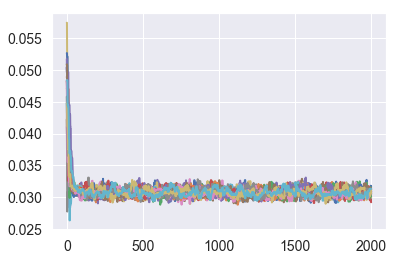

In [9]:
for i in range(20):
    plt.plot(sampler.chain[i, :, 0])

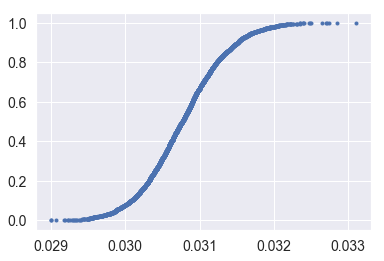

In [11]:
samples_k = sampler.chain[:, 250::10, 0].flatten()
samples_N0 = sampler.chain[:, 250::10, 1].flatten()
plt.plot(np.sort(samples_k), np.arange(1, len(samples_k)+1)/len(samples_k), '.')

(array([  3.,   5.,  10.,  27.,  38.,  54., 107., 123., 187., 257., 304.,
        342., 317., 365., 314., 275., 212., 161., 142.,  88.,  58.,  42.,
         34.,  17.,   9.,   3.,   1.,   3.,   1.,   1.]),
 array([0.02900681, 0.02914335, 0.0292799 , 0.02941644, 0.02955298,
        0.02968952, 0.02982606, 0.0299626 , 0.03009915, 0.03023569,
        0.03037223, 0.03050877, 0.03064531, 0.03078186, 0.0309184 ,
        0.03105494, 0.03119148, 0.03132802, 0.03146456, 0.03160111,
        0.03173765, 0.03187419, 0.03201073, 0.03214727, 0.03228381,
        0.03242036, 0.0325569 , 0.03269344, 0.03282998, 0.03296652,
        0.03310306]),
 <a list of 30 Patch objects>)

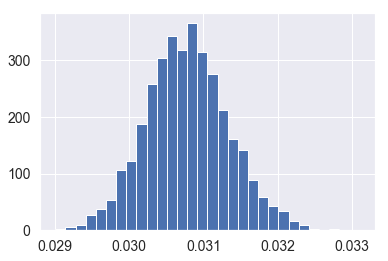

In [12]:
plt.hist(samples_k, bins=30)

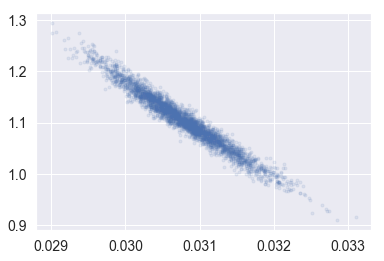

In [13]:
plt.plot(samples_k, samples_N0, '.', alpha=0.1)